# Token Diffusion Analysis: Brownian vs Ballistic Motion

**Are token movements during training consistent with random walks (Brownian motion) or directed motion (ballistic/superdiffusive)?**

## Theory

In a random walk with N steps of typical size σ, the expected displacement scales as:

$$\text{RMS distance} = \sqrt{N} \cdot \sigma$$

We can classify each token's motion by comparing its actual final distance to this prediction:

**Diffusivity ratio:**
$$D = \frac{d_{\text{actual}}^2}{N \cdot \sigma^2}$$

Where:
- **D ≈ 1:** Brownian motion (random walk)
- **D < 1:** Subdiffusive (confined, trapped, or dead)
- **D > 1:** Superdiffusive (driven, ballistic, or kicked)

## Hypothesis

If "dead" tokens exist and don't participate in learning:
- Dead tokens should show D ≤ 1 (Brownian or subdiffusive)
- Live tokens (appearing in training text) should show D > 1 (superdiffusive)
- This would create a **bimodal distribution** of diffusivities

## Parameters

In [9]:
# Data source - change this to analyze different runs
TRAINING_DATA_PATH = '../tensors/Lil_Gatsby/1.9d_training_data.safetensors'
RUN_NAME = '1.9d (vanilla SGD, lr=0.1, batch=1)'

# Analysis
N_STEPS = 1000  # Number of training steps to analyze (not including init)

# Known token categories (optional, for validation)
# If you have lists of dead/live token IDs, set them here
DEAD_TOKENS = None  # e.g., [0, 1, 2, ...] or load from file
LIVE_TOKENS = None  # e.g., [32, 65, 97, ...] or load from file

# Visualization
DPI = 100
COLORMAP = 'inferno'

## Imports

In [10]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from scipy import stats

## Device Detection

In [11]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

Using device: mps


## Load Data

In [12]:
data = load_file(TRAINING_DATA_PATH)
embeddings = data['embeddings']  # (n_steps, 128, 64)

# Load token categories if available
if 'dead_token_ids' in data and DEAD_TOKENS is None:
    DEAD_TOKENS = data['dead_token_ids'].cpu().numpy()
    print(f'Loaded {len(DEAD_TOKENS)} dead tokens from file')

if 'live_token_ids' in data and LIVE_TOKENS is None:
    LIVE_TOKENS = data['live_token_ids'].cpu().numpy()
    print(f'Loaded {len(LIVE_TOKENS)} live tokens from file')

print(f'Loaded: {RUN_NAME}')
print(f'Embeddings shape: {embeddings.shape}')
print(f'Steps available: {embeddings.shape[0]}')
print(f'Analyzing first {N_STEPS} steps')
print()

# Validate N_STEPS
if N_STEPS + 1 > embeddings.shape[0]:
    print(f'WARNING: Requested {N_STEPS} steps but only {embeddings.shape[0]-1} available')
    N_STEPS = embeddings.shape[0] - 1
    print(f'Adjusted to {N_STEPS} steps')
    print()

Loaded 50 dead tokens from file
Loaded 78 live tokens from file
Loaded: 1.9d (vanilla SGD, lr=0.1, batch=1)
Embeddings shape: torch.Size([1001, 128, 64])
Steps available: 1001
Analyzing first 1000 steps



## Compute Step Sizes

In [13]:
print('Computing step-by-step displacements...')
print()

n_tokens = embeddings.shape[1]

# Compute all step-to-step displacements
# For each token, for each step: ||emb[t] - emb[t-1]||
step_norms = np.zeros((N_STEPS, n_tokens))

for step_idx in range(1, N_STEPS + 1):
    emb_prev = embeddings[step_idx - 1].cpu().numpy()
    emb_curr = embeddings[step_idx].cpu().numpy()
    
    displacements = emb_curr - emb_prev
    norms = np.linalg.norm(displacements, axis=1)  # (128,)
    
    step_norms[step_idx - 1] = norms

print(f'✓ Computed {N_STEPS} step displacements for {n_tokens} tokens')
print()

# Estimate typical step size σ
# Problem: Many steps have zero displacement (sparse updates)
# Solution: Use RMS of ALL steps (including zeros) - this is the actual step size distribution

all_step_norms = step_norms.flatten()
sigma_rms = np.sqrt(np.mean(all_step_norms ** 2))  # RMS
sigma_mean = all_step_norms.mean()
sigma_median = np.median(all_step_norms)

# Also compute per-token RMS (accounts for different tokens moving at different rates)
sigma_per_token = np.sqrt(np.mean(step_norms ** 2, axis=0))  # (128,)

print('Step size statistics (all tokens, all steps):')
print(f'  Mean step size: {sigma_mean:.6f}')
print(f'  Median step size: {sigma_median:.6f}')
print(f'  RMS step size: {sigma_rms:.6f}')
print(f'  Min per-token RMS: {sigma_per_token.min():.6f}')
print(f'  Max per-token RMS: {sigma_per_token.max():.6f}')
print()

if sigma_rms < 1e-10:
    print('WARNING: RMS step size is essentially zero!')
    print('This dataset may not have enough movement for diffusion analysis.')
    sigma_to_use = sigma_mean if sigma_mean > 0 else 1e-6
    print(f'Using fallback σ = {sigma_to_use:.6f}')
else:
    sigma_to_use = sigma_rms
    print(f'Using σ = {sigma_to_use:.6f} (RMS) for Brownian motion prediction')

Computing step-by-step displacements...

✓ Computed 1000 step displacements for 128 tokens

Step size statistics (all tokens, all steps):
  Mean step size: 0.001462
  Median step size: 0.000000
  RMS step size: 0.004636
  Min per-token RMS: 0.000504
  Max per-token RMS: 0.016713

Using σ = 0.004636 (RMS) for Brownian motion prediction


## Compute Final Displacements and Diffusivities

In [14]:
print('Computing final displacements and diffusivity ratios...')
print()

# Initial and final positions
emb_init = embeddings[0].cpu().numpy()  # (128, 64)
emb_final = embeddings[N_STEPS].cpu().numpy()  # (128, 64)

# Displacement vectors
total_displacement = emb_final - emb_init  # (128, 64)
final_distances = np.linalg.norm(total_displacement, axis=1)  # (128,)

# Expected distance for Brownian motion
expected_distance_brownian = np.sqrt(N_STEPS) * sigma_to_use

# Diffusivity ratio: D = d²/(N·σ²)
if sigma_to_use > 0:
    diffusivity = (final_distances ** 2) / (N_STEPS * sigma_to_use ** 2)
else:
    diffusivity = np.full(n_tokens, np.inf)

print(f'✓ Computed final displacements for {n_tokens} tokens')
print()
print('Brownian motion prediction:')
print(f'  Expected RMS distance: {expected_distance_brownian:.6f}')
print()
print('Actual distances:')
print(f'  Mean: {final_distances.mean():.6f}')
print(f'  Median: {np.median(final_distances):.6f}')
print(f'  Min: {final_distances.min():.6f}')
print(f'  Max: {final_distances.max():.6f}')
print()

# Check if diffusivity is valid
if np.all(np.isinf(diffusivity)):
    print('ERROR: All diffusivities are infinite (sigma too small)')
else:
    valid_D = diffusivity[np.isfinite(diffusivity)]
    print('Diffusivity ratios:')
    print(f'  Mean D: {valid_D.mean():.4f}')
    print(f'  Median D: {np.median(valid_D):.4f}')
    print(f'  Min D: {valid_D.min():.4f}')
    print(f'  Max D: {valid_D.max():.4f}')

Computing final displacements and diffusivity ratios...

✓ Computed final displacements for 128 tokens

Brownian motion prediction:
  Expected RMS distance: 0.146601

Actual distances:
  Mean: 0.221472
  Median: 0.068423
  Min: 0.024913
  Max: 0.862639

Diffusivity ratios:
  Mean D: 4.8347
  Median D: 0.2178
  Min D: 0.0289
  Max D: 34.6247


## Classification

In [15]:
# Classify tokens by diffusivity
# Use factor of 2 as threshold (somewhat arbitrary but reasonable)
subdiffusive_mask = diffusivity < 0.5
brownian_mask = (diffusivity >= 0.5) & (diffusivity <= 2.0)
superdiffusive_mask = diffusivity > 2.0

print('='*70)
print('DIFFUSION CLASSIFICATION')
print('='*70)
print()
print(f'Subdiffusive (D < 0.5): {subdiffusive_mask.sum()} tokens')
print(f'Brownian (0.5 ≤ D ≤ 2.0): {brownian_mask.sum()} tokens')
print(f'Superdiffusive (D > 2.0): {superdiffusive_mask.sum()} tokens')
print()

# If we have dead/live token labels, check overlap
if DEAD_TOKENS is not None:
    dead_mask = np.isin(np.arange(n_tokens), DEAD_TOKENS)
    
    dead_subdiffusive = (dead_mask & subdiffusive_mask).sum()
    dead_brownian = (dead_mask & brownian_mask).sum()
    dead_superdiffusive = (dead_mask & superdiffusive_mask).sum()
    
    print(f'Dead tokens ({len(DEAD_TOKENS)} total):')
    print(f'  Subdiffusive: {dead_subdiffusive}')
    print(f'  Brownian: {dead_brownian}')
    print(f'  Superdiffusive: {dead_superdiffusive}')
    print()

if LIVE_TOKENS is not None:
    live_mask = np.isin(np.arange(n_tokens), LIVE_TOKENS)
    
    live_subdiffusive = (live_mask & subdiffusive_mask).sum()
    live_brownian = (live_mask & brownian_mask).sum()
    live_superdiffusive = (live_mask & superdiffusive_mask).sum()
    
    print(f'Live tokens ({len(LIVE_TOKENS)} total):')
    print(f'  Subdiffusive: {live_subdiffusive}')
    print(f'  Brownian: {live_brownian}')
    print(f'  Superdiffusive: {live_superdiffusive}')
    print()

print('='*70)

DIFFUSION CLASSIFICATION

Subdiffusive (D < 0.5): 78 tokens
Brownian (0.5 ≤ D ≤ 2.0): 8 tokens
Superdiffusive (D > 2.0): 42 tokens

Dead tokens (50 total):
  Subdiffusive: 50
  Brownian: 0
  Superdiffusive: 0

Live tokens (78 total):
  Subdiffusive: 28
  Brownian: 8
  Superdiffusive: 42



## Visualization: Diffusivity Distribution

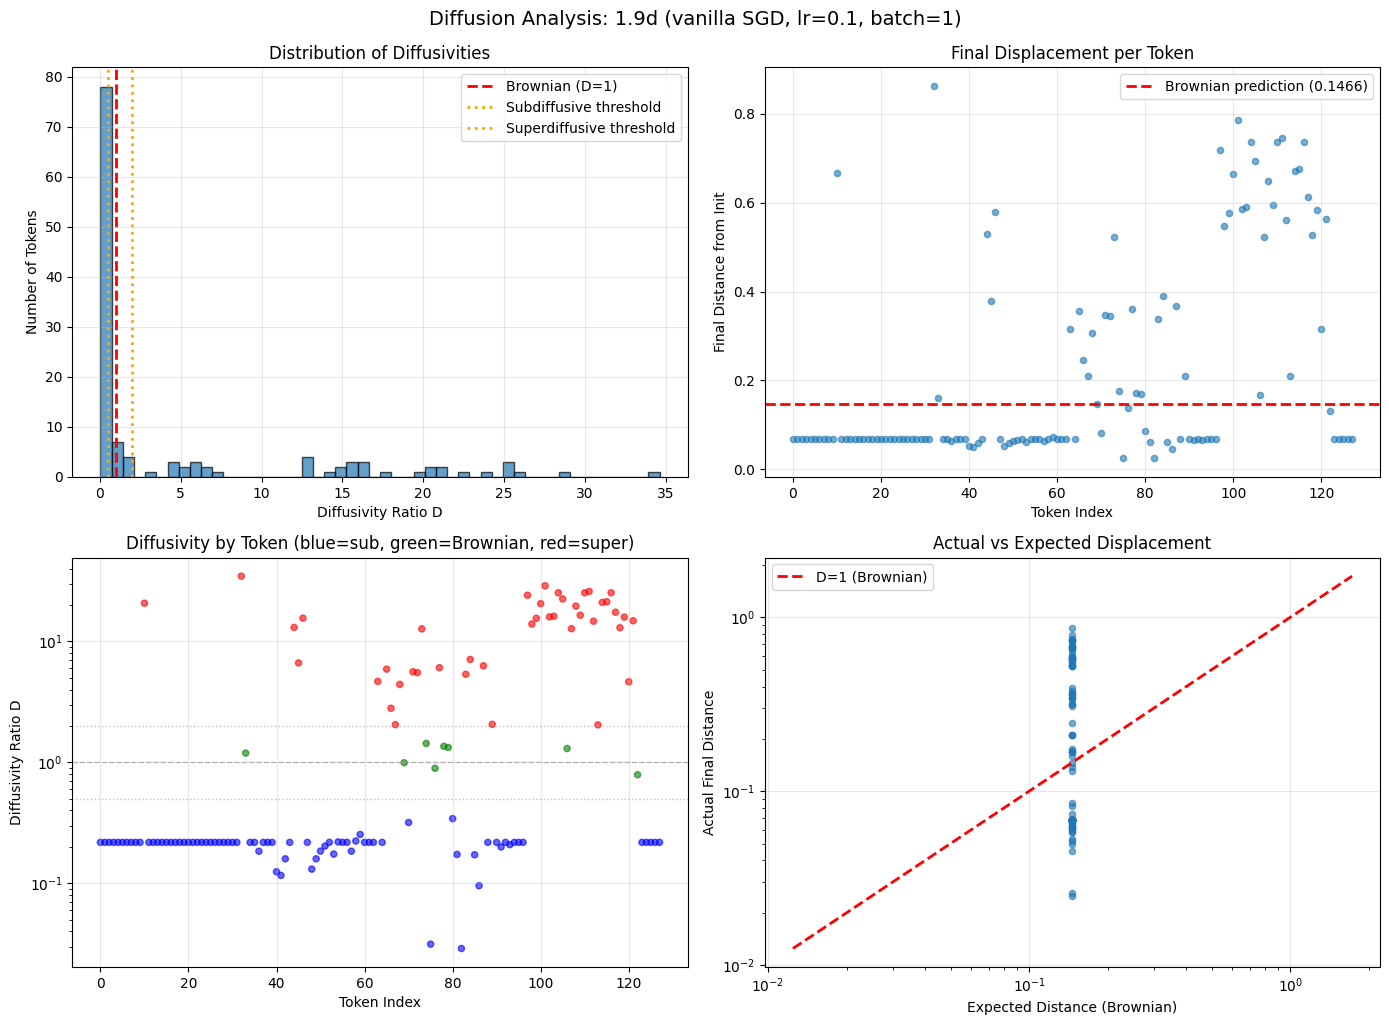

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=DPI)

# Filter out any inf/nan values for plotting
valid_mask = np.isfinite(diffusivity)
valid_diffusivity = diffusivity[valid_mask]

if len(valid_diffusivity) == 0:
    print('ERROR: No valid diffusivity values to plot!')
else:
    # Top-left: Histogram of diffusivity ratios
    ax = axes[0, 0]
    ax.hist(valid_diffusivity, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(1.0, color='r', linestyle='--', linewidth=2, label='Brownian (D=1)')
    ax.axvline(0.5, color='orange', linestyle=':', linewidth=2, label='Subdiffusive threshold')
    ax.axvline(2.0, color='orange', linestyle=':', linewidth=2, label='Superdiffusive threshold')
    ax.set_xlabel('Diffusivity Ratio D')
    ax.set_ylabel('Number of Tokens')
    ax.set_title('Distribution of Diffusivities')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Top-right: Final distance vs expected
    ax = axes[0, 1]
    ax.scatter(np.arange(n_tokens), final_distances, s=20, alpha=0.6)
    ax.axhline(expected_distance_brownian, color='r', linestyle='--', linewidth=2, 
               label=f'Brownian prediction ({expected_distance_brownian:.4f})')
    ax.set_xlabel('Token Index')
    ax.set_ylabel('Final Distance from Init')
    ax.set_title('Final Displacement per Token')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Bottom-left: Diffusivity vs token index (color-coded)
    ax = axes[1, 0]
    colors = ['blue' if d < 0.5 else 'green' if d <= 2.0 else 'red' for d in diffusivity]
    ax.scatter(np.arange(n_tokens), diffusivity, c=colors, s=20, alpha=0.6)
    ax.axhline(1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    ax.axhline(2.0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    ax.set_xlabel('Token Index')
    ax.set_ylabel('Diffusivity Ratio D')
    ax.set_title('Diffusivity by Token (blue=sub, green=Brownian, red=super)')
    ax.set_yscale('log')
    ax.grid(alpha=0.3)
    
    # Bottom-right: Log-log plot of actual vs expected distance
    ax = axes[1, 1]
    if expected_distance_brownian > 0:
        ax.scatter(expected_distance_brownian * np.ones(n_tokens), final_distances, s=20, alpha=0.6)
        ax.plot([final_distances.min()/2, final_distances.max()*2], 
                [final_distances.min()/2, final_distances.max()*2], 
                'r--', linewidth=2, label='D=1 (Brownian)')
        ax.set_xlabel('Expected Distance (Brownian)')
        ax.set_ylabel('Actual Final Distance')
        ax.set_title('Actual vs Expected Displacement')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'Expected distance = 0\n(Cannot plot log scale)', 
                ha='center', va='center', transform=ax.transAxes)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'Diffusion Analysis: {RUN_NAME}', y=1.02, fontsize=14)
    plt.show()

## Dead vs Live Token Analysis

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_33975/437466536.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([dead_D, live_D], labels=['Dead', 'Live'])


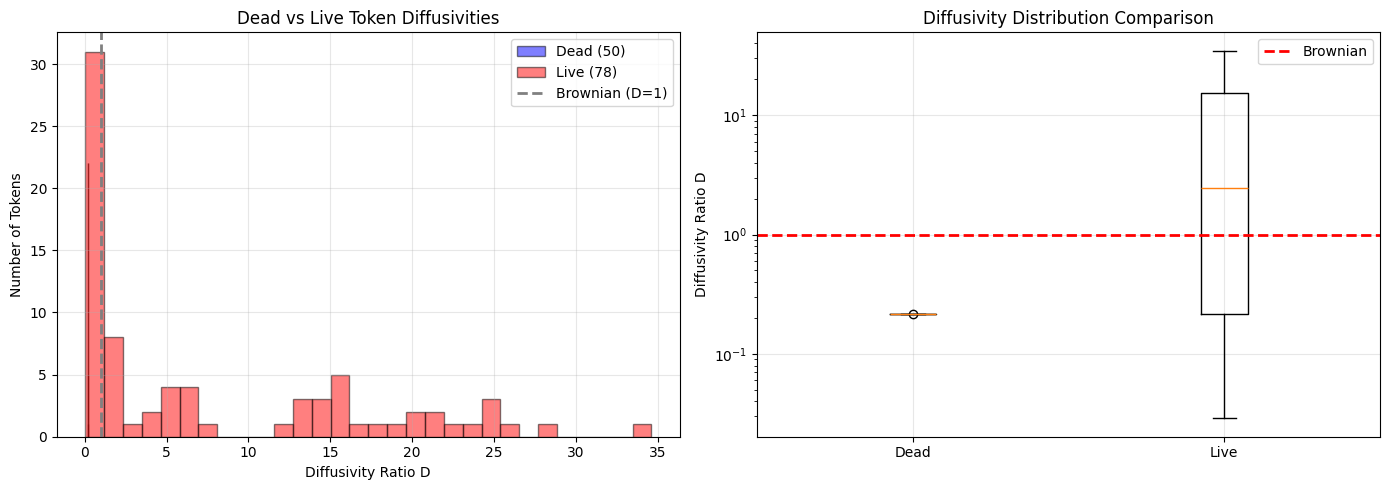

STATISTICAL COMPARISON: Dead vs Live Tokens

Dead tokens mean D: 0.2178
Live tokens mean D: 7.7943

Mann-Whitney U test:
  U statistic: 961.00
  p-value: 0.000001
  ✓ HIGHLY SIGNIFICANT difference (p < 0.001)


In [17]:
if DEAD_TOKENS is not None and LIVE_TOKENS is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)
    
    dead_mask = np.isin(np.arange(n_tokens), DEAD_TOKENS)
    live_mask = np.isin(np.arange(n_tokens), LIVE_TOKENS)
    
    dead_D = diffusivity[dead_mask]
    live_D = diffusivity[live_mask]
    
    # Left: Overlapping histograms
    ax = axes[0]
    ax.hist(dead_D, bins=30, alpha=0.5, label=f'Dead ({len(dead_D)})', color='blue', edgecolor='black')
    ax.hist(live_D, bins=30, alpha=0.5, label=f'Live ({len(live_D)})', color='red', edgecolor='black')
    ax.axvline(1.0, color='gray', linestyle='--', linewidth=2, label='Brownian (D=1)')
    ax.set_xlabel('Diffusivity Ratio D')
    ax.set_ylabel('Number of Tokens')
    ax.set_title('Dead vs Live Token Diffusivities')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Right: Box plots
    ax = axes[1]
    ax.boxplot([dead_D, live_D], labels=['Dead', 'Live'])
    ax.axhline(1.0, color='r', linestyle='--', linewidth=2, label='Brownian')
    ax.set_ylabel('Diffusivity Ratio D')
    ax.set_title('Diffusivity Distribution Comparison')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical test
    print('='*70)
    print('STATISTICAL COMPARISON: Dead vs Live Tokens')
    print('='*70)
    print()
    print(f'Dead tokens mean D: {dead_D.mean():.4f}')
    print(f'Live tokens mean D: {live_D.mean():.4f}')
    print()
    
    # Mann-Whitney U test (non-parametric)
    statistic, pvalue = stats.mannwhitneyu(dead_D, live_D, alternative='two-sided')
    print(f'Mann-Whitney U test:')
    print(f'  U statistic: {statistic:.2f}')
    print(f'  p-value: {pvalue:.6f}')
    
    if pvalue < 0.001:
        print('  ✓ HIGHLY SIGNIFICANT difference (p < 0.001)')
    elif pvalue < 0.05:
        print('  ✓ Significant difference (p < 0.05)')
    else:
        print('  ✗ No significant difference')
    
    print('='*70)
else:
    print('No dead/live token labels available. Skipping comparison.')

## Extreme Cases: Most and Least Diffusive

In [18]:
print('='*70)
print('EXTREME CASES')
print('='*70)
print()

# Top 10 most superdiffusive
top_indices = np.argsort(diffusivity)[::-1][:10]
print('Top 10 most superdiffusive tokens:')
for i, idx in enumerate(top_indices):
    char = chr(idx) if 32 <= idx < 127 else f'\\x{idx:02x}'
    print(f"  {i+1}. Token {idx:3d} ('{char}'): D={diffusivity[idx]:.4f}, distance={final_distances[idx]:.6f}")
print()

# Top 10 most subdiffusive
bottom_indices = np.argsort(diffusivity)[:10]
print('Top 10 most subdiffusive tokens:')
for i, idx in enumerate(bottom_indices):
    char = chr(idx) if 32 <= idx < 127 else f'\\x{idx:02x}'
    print(f"  {i+1}. Token {idx:3d} ('{char}'): D={diffusivity[idx]:.4f}, distance={final_distances[idx]:.6f}")

print('='*70)

EXTREME CASES

Top 10 most superdiffusive tokens:
  1. Token  32 (' '): D=34.6247, distance=0.862639
  2. Token 101 ('e'): D=28.8159, distance=0.786959
  3. Token 111 ('o'): D=25.8779, distance=0.745762
  4. Token 116 ('t'): D=25.2466, distance=0.736611
  5. Token 110 ('n'): D=25.2200, distance=0.736222
  6. Token 104 ('h'): D=25.2024, distance=0.735965
  7. Token  97 ('a'): D=24.0735, distance=0.719293
  8. Token 105 ('i'): D=22.4370, distance=0.694414
  9. Token 115 ('s'): D=21.2575, distance=0.675915
  10. Token 114 ('r'): D=21.0042, distance=0.671876

Top 10 most subdiffusive tokens:
  1. Token  82 ('R'): D=0.0289, distance=0.024913
  2. Token  75 ('K'): D=0.0314, distance=0.025965
  3. Token  86 ('V'): D=0.0954, distance=0.045286
  4. Token  41 (')'): D=0.1160, distance=0.049936
  5. Token  40 ('('): D=0.1246, distance=0.051746
  6. Token  48 ('0'): D=0.1309, distance=0.053031
  7. Token  42 ('*'): D=0.1593, distance=0.058518
  8. Token  49 ('1'): D=0.1594, distance=0.058527
  9. 

## Final Verdict

In [19]:
print('='*70)
print('DIFFUSION ANALYSIS: FINAL VERDICT')
print('='*70)
print()
print(f'Run: {RUN_NAME}')
print(f'Steps analyzed: {N_STEPS}')
print()

mean_D = diffusivity.mean()
median_D = np.median(diffusivity)

print(f'Overall diffusivity: mean={mean_D:.4f}, median={median_D:.4f}')
print()

if median_D > 2.0:
    print('→ SUPERDIFFUSIVE REGIME: Tokens are driven/ballistic')
    print('  Most tokens moved farther than random walk prediction')
    print('  Suggests strong directional gradients')
elif median_D < 0.5:
    print('→ SUBDIFFUSIVE REGIME: Tokens are confined/trapped')
    print('  Most tokens moved less than random walk prediction')
    print('  Suggests constraints or dead tokens')
elif 0.8 <= median_D <= 1.2:
    print('→ BROWNIAN REGIME: Random walk dynamics')
    print('  Token movements consistent with thermal diffusion')
    print('  No strong directional bias')
else:
    print('→ MIXED REGIME')
    print('  Some tokens superdiffusive, some subdiffusive')
    print('  Check distribution for bimodality')

# Check for bimodality
log_D = np.log10(diffusivity)
hist, bin_edges = np.histogram(log_D, bins=20)
peaks = (hist[1:-1] > hist[:-2]) & (hist[1:-1] > hist[2:])
n_peaks = peaks.sum()

print()
if n_peaks >= 2:
    print(f'Distribution shows {n_peaks} peaks → likely BIMODAL')
    print('  → Suggests two populations (e.g., dead vs live tokens)')
else:
    print('Distribution appears unimodal')

print('='*70)

DIFFUSION ANALYSIS: FINAL VERDICT

Run: 1.9d (vanilla SGD, lr=0.1, batch=1)
Steps analyzed: 1000

Overall diffusivity: mean=4.8347, median=0.2178

→ SUBDIFFUSIVE REGIME: Tokens are confined/trapped
  Most tokens moved less than random walk prediction
  Suggests constraints or dead tokens

Distribution shows 5 peaks → likely BIMODAL
  → Suggests two populations (e.g., dead vs live tokens)


In [ ]:
blue_mask = (diffusivity > 0.19) & (diffusivity < 0.21)
blue_distances = final_distances[blue_mask]
print(f"Unique distances: {np.unique(blue_distances)}")

Unique distances: [0.06551025 0.06604408 0.06695429]


In [23]:
blue_mask = (diffusivity > 0.19) & (diffusivity < 0.21)
blue_indices = np.where(blue_mask)[0]

for dist in np.unique(blue_distances):
    matching = blue_indices[blue_distances == dist]
    print(f"\nDistance {dist:.8f}: {len(matching)} tokens")
    print(f"  Token IDs: {matching}")
    print(f"  Characters: {[chr(i) if 32 <= i < 127 else f'\\\\x{i:02x}' for i in matching[:10]]}")


Distance 0.06551025: 1 tokens
  Token IDs: [91]
  Characters: ['[']

Distance 0.06604408: 1 tokens
  Token IDs: [51]
  Characters: ['3']

Distance 0.06695429: 1 tokens
  Token IDs: [93]
  Characters: [']']
